# PCA, Autoencoders

### import, load etc

In [1]:
#%env CUDA_VISIBLE_DEVICES=1

import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True,per_process_gpu_memory_fraction=0.333)
s = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import numpy as np

import tensorflow as tf
import keras

Using TensorFlow backend.


In [2]:
from lfw_dataset import fetch_lfw_dataset

In [3]:
X, attr = fetch_lfw_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [4]:
X = X.astype('float32') / 256.0

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(X, test_size=0.1)

## Faces!

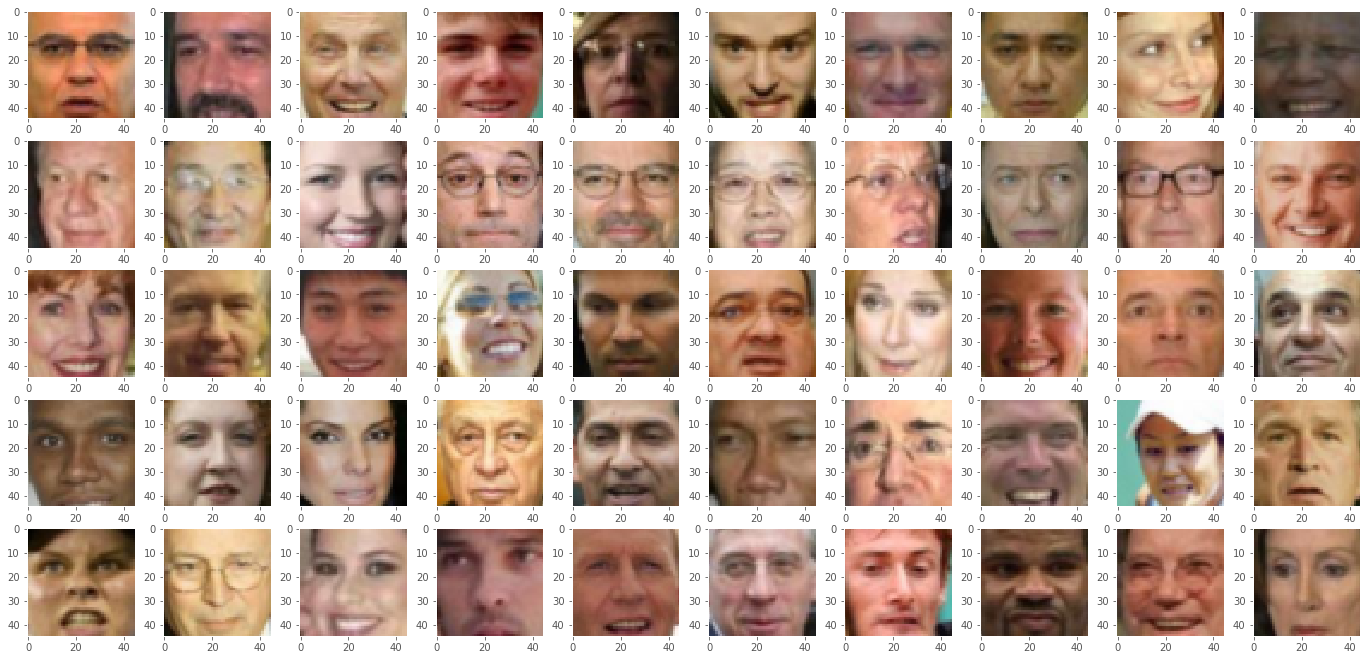

In [6]:
cols = 10
rows = 5
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        k = np.random.randint(0, X_train.shape[0])

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        im = ax.imshow(X_train[k])
plt.show()

## Simple start: PCA

Just a cheat sheet:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

- $n$ - number of objects;
- $m$ - original dimensionality;
- $d$ - target dimensionality;
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;

    $$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$


### PCA = DenseLayer(activation=linear) -> DenseLayer(activation=linear)

PCA can be seen as a special case of an Neural Network.

Consider a dense layer with $d$ units:
    $$\mathrm{dense}(X) = f(X W + b)$$
where:
- $f$ - nonlinearity (sigmoid, $\tanh$ etc);
- $X \in \mathbb{R}^{n \times m}$ - object matrix;
- $W \in \mathrm{m \times d}$, $b \in \mathbb{R}^d$ - layer's parameters;

and PCA:
   $$\|(X W) \hat{W} - X - \mu\|^2_2 \to_{W, \hat{W}} \min$$

where:
  - $W$ - orthogonal.

In [9]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Reshape, Flatten

In [10]:
def make_pca():
    inputs = Input(shape=(45, 45, 3))
    
    ### Dense layer can only accept 2D tensor,
    ### so reshaping is done to flatten image tensor.
    flatten = Reshape((45 * 45 * 3, ))(inputs)
    
    ###
    ### your PCA here
    ###
    encoded = Dense(64, activation="linear")(flatten)
    decoded = Dense(45*45*3, activation="linear")(encoded)

    shaped = Reshape((45, 45, 3))(decoded)
    
    return Model(inputs=inputs, outputs=shaped), Model(inputs=inputs, outputs=encoded)

In [11]:
pca, pca_encoder = make_pca()

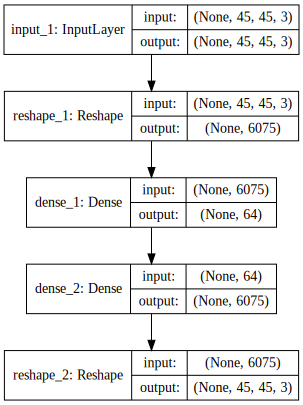

In [12]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(pca, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
from keras.optimizers import Adamax
from keras.objectives import MSE

In [14]:
pca.compile(optimizer=Adamax(lr=1.0e-3), loss=[MSE])

In [15]:
pca.fit(X_train, X_train, epochs=16)

Epoch 1/16
11828/11828 [==============================] - 2s - loss: 0.0237     
Epoch 2/16
11828/11828 [==============================] - 2s - loss: 0.0115     
Epoch 3/16
11828/11828 [==============================] - 2s - loss: 0.0093     
Epoch 4/16
11828/11828 [==============================] - 1s - loss: 0.0077     
Epoch 5/16
11828/11828 [==============================] - 1s - loss: 0.0065     
Epoch 6/16
11828/11828 [==============================] - 1s - loss: 0.0057     
Epoch 7/16
11828/11828 [==============================] - 1s - loss: 0.0050     
Epoch 8/16
11828/11828 [==============================] - 1s - loss: 0.0045     
Epoch 9/16
11828/11828 [==============================] - 1s - loss: 0.0042     
Epoch 10/16
11828/11828 [==============================] - 1s - loss: 0.0039     
Epoch 11/16
11828/11828 [==============================] - 1s - loss: 0.0037     
Epoch 12/16
11828/11828 [==============================] - 1s - loss: 0.0036     
Epoch 13/16
11828/11828 [

In [16]:
X_reco = pca.predict(X_test)
code = pca_encoder.predict(X_test)

In [17]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.00323193


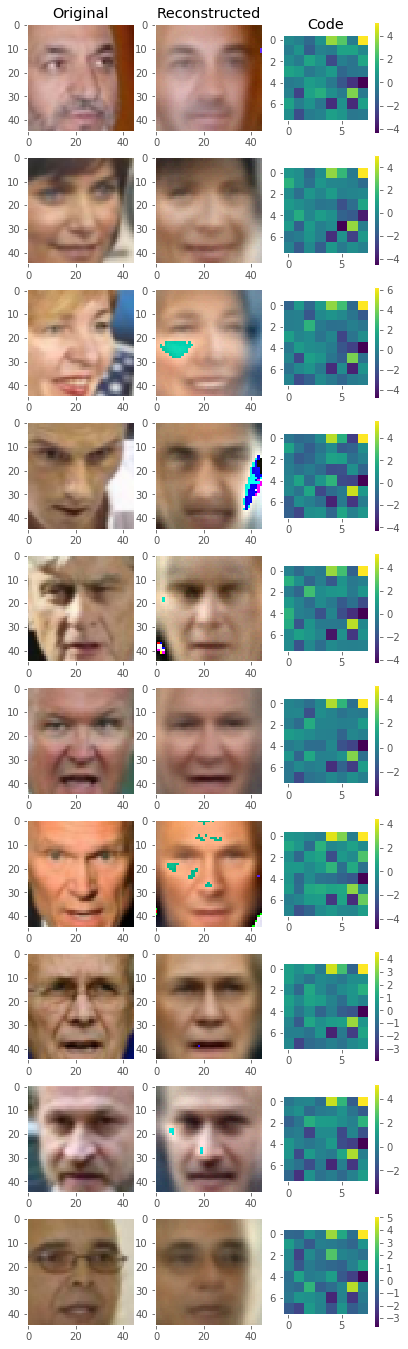

In [18]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(8, 8), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

## Extending to AutoEncoder

Just add more layers!

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

In [20]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Reshape, BatchNormalization
from keras.activations import relu, elu, tanh
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal, glorot_uniform

In [34]:
def make_autoencoder():
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    regularization_coef = 1.0e-10
    
    inputs = Input(shape=(45, 45, 3))
    flatten = Reshape((45 * 45 * 3, ))(inputs)
    
    ###
    ### STACK MORE LAYERS here.
    ###
    # Encode
    encoded = Dense(1024,
                activation="tanh")(flatten)
    net = Dense(512,
                activation="tanh")(encoded)
    net = Dense(256,
                activation="tanh")(net)
    net = Dense(128,
                activation="tanh")(net)
    net = Dense(64,
                activation="tanh")(net)
    # Decode
    net = Dense(128,
                activation="tanh")(net)
    net = Dense(256,
                activation="tanh")(net)
    net = Dense(512,
                activation="tanh")(net)
    net = Dense(1024,
                activation="tanh")(net)
    
    decoded = Dense(45*45*3,
                   activation="tanh")(net)

    shaped = Reshape((45, 45, 3), name='decoded')(decoded)
    
    return Model(inputs=inputs, outputs=shaped), Model(inputs=inputs, outputs=encoded)

In [35]:
ae, ae_encoder = make_autoencoder()

In [36]:
from keras.optimizers import Adadelta
from keras.objectives import MSE

In [37]:
ae.compile(optimizer=Adadelta(), loss=MSE)

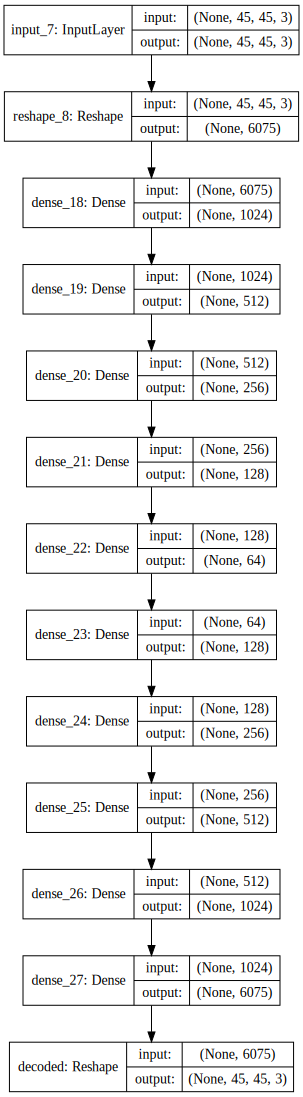

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(ae, show_shapes=True).create(prog='dot', format='svg'))

In [39]:
ae.fit(X_train, X_train, epochs=16)

Epoch 1/16
11828/11828 [==============================] - 11s - loss: 0.0374    
Epoch 2/16
11828/11828 [==============================] - 10s - loss: 0.0232    
Epoch 3/16
11828/11828 [==============================] - 10s - loss: 0.0218    
Epoch 4/16
11828/11828 [==============================] - 10s - loss: 0.0207    
Epoch 5/16
11828/11828 [==============================] - 10s - loss: 0.0188    
Epoch 6/16
11828/11828 [==============================] - 12s - loss: 0.0174    
Epoch 7/16
11828/11828 [==============================] - 12s - loss: 0.0164    
Epoch 8/16
11828/11828 [==============================] - 12s - loss: 0.0155    
Epoch 9/16
11828/11828 [==============================] - 11s - loss: 0.0148    
Epoch 10/16
11828/11828 [==============================] - 11s - loss: 0.0143    
Epoch 11/16
11828/11828 [==============================] - 10s - loss: 0.0138    
Epoch 12/16
11828/11828 [==============================] - 10s - loss: 0.0134    
Epoch 13/16
11828/11828 [

In [40]:
X_reco = ae.predict(X_test)
code = ae_encoder.predict(X_test)

In [41]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.0118291


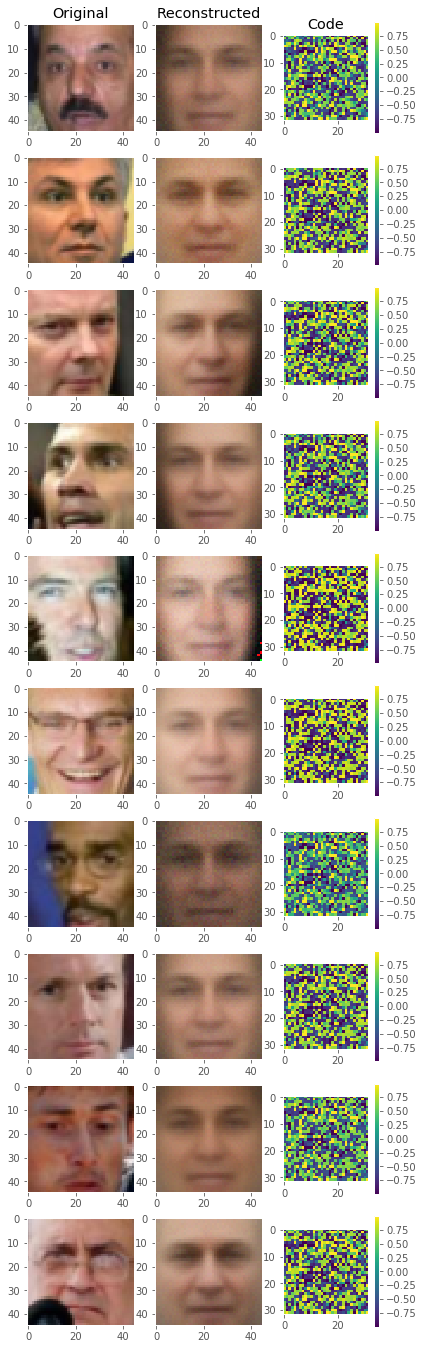

In [43]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(32, 32), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

### Images $\Rightarrow$ convolutions

In [44]:
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal
from keras.activations import relu
from keras.losses import MSE

In [87]:
def make_conv_autoencoder():
    inputs = Input(shape=(45, 45, 3))
    net = inputs
    
    leaky_relu = lambda x: relu(x, alpha=5.0e-2)
    
    encoded = Conv2D(filters=32, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(encoded)
    
    ###
    ### Please, convolve here.
    ###
    net = Conv2D(filters=16, kernel_size=(2, 2), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    
    net = Conv2D(filters=8, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    #net = MaxPooling2D()(net)
    
    #net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 16, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    
    net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 32, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    
    net = UpSampling2D()(net)
    net = Conv2DTranspose(filters = 3, kernel_size=(2, 2), activation='linear', padding='valid')(net)
    
    ### if resulting image is larger than the original
    ### consider using cropping layer.
    #net = Cropping2D(cropping=((1, 0), (1, 0)))(net)
    
    return Model(inputs=inputs, outputs=net), Model(inputs=inputs, outputs=encoded)

In [88]:
cae, cae_encoder = make_conv_autoencoder()

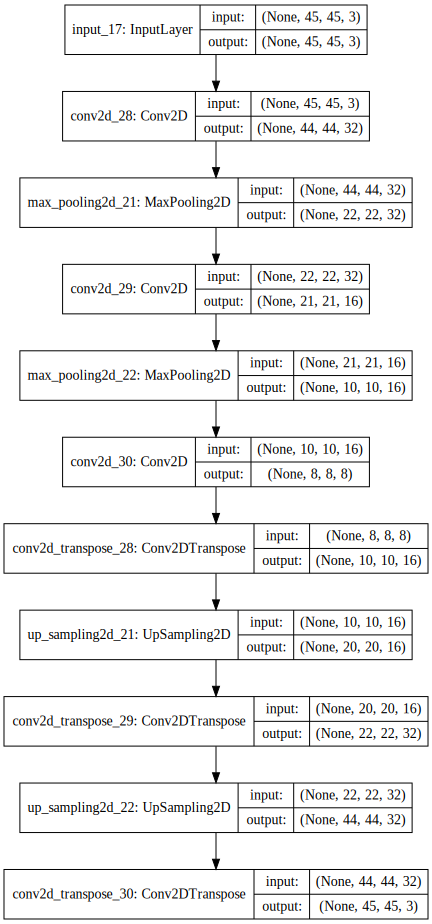

In [89]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(cae, show_shapes=True).create(prog='dot', format='svg'))

In [90]:
### Just for fun, let's see how MAE-based AE differs from MSE-based one.
### Plus MAE contains AE...
cae.compile(optimizer='adamax', loss=MSE)

In [86]:
cae.fit(X_train, X_train, epochs=32)

ValueError: Error when checking input: expected input_16 to have shape (None, 45, 45, 3) but got array with shape (50000, 28, 28, 1)

In [71]:
X_reco = cae.predict(X_test)
code = cae_encoder.predict(X_test)

In [72]:
print('Test MSE:', np.mean((X_reco - X_test) ** 2))

Test MSE: 0.00291606


ValueError: cannot reshape array of size 61952 into shape (8,8)

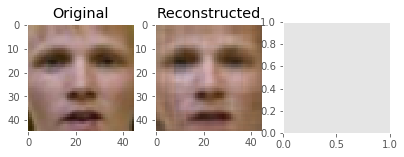

In [73]:
cols = 3
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
    ax = fig.add_subplot(rows, cols, i * cols + 3)
    ax.grid('off')
    im = ax.imshow(code[k].reshape(8, 8), cmap=plt.cm.viridis)
    cb = fig.colorbar(im)
    if i == 0:
        ax.set_title('Code')
    
plt.show()

## Fully Convolutional Denoising AutoEncoder

The idea behind denoising AutoEncoder is define behaviour of the AutoEncoder on points close to these from dataset:
    $$\left\| \mathrm{decode}(\mathrm{encode}(X + \varepsilon))) -X \right\|^2_2 \to \min$$
    
where:
- $\varepsilon \sim \mathcal{N}(0, \sigma^2_\varepsilon)$    

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, GaussianNoise, Dropout
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Cropping2D
from keras.regularizers import l1, l2
from keras.initializers import Orthogonal
from keras.activations import relu
from keras.losses import MAE, MSE

In [ ]:
def make_denoising_conv_autoencoder(dropout_p = None, noise_stddev=0.1):
    inputs = Input(shape=(45, 45, 3))
    
    leaky_relu = lambda x: relu(x, alpha=2.5e-2)
    
    noise = GaussianNoise(stddev=noise_stddev)(inputs)
    
    net = noise
    
    ###
    ### Paste you fully convolution AutoEncoder here.
    ###

    net = Conv2DTranspose(filters = 3, kernel_size=(2, 2), activation='linear', padding='valid')(net)
    
    return Model(inputs=inputs, outputs=net)

In [ ]:
dfcae = make_denoising_conv_autoencoder()

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(dfcae, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
dfcae.compile(optimizer='adamax', loss=MSE)

In [ ]:
dfcae.fit(X_train, X_train, epochs=64)

In [ ]:
X_reco = dfcae.predict(X_test)

In [ ]:
print(np.mean((X_reco - X_test) ** 2))

In [ ]:
cols = 2
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_test.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_test[k])
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k])
    if i == 0:
        ax.set_title('Reconstructed')
    
plt.show()

## Bonus: cheap generative model

A simple generative model (almost) is implemented below.

See Bengio, Yoshua, et al. "Deep generative stochastic networks trainable by backprop." International Conference on Machine Learning. 2014. for a more advanced method.

In [82]:
from mnist import load_dataset

In [83]:
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [84]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)

In [ ]:
def make_mnist_autoencoder(dropout_p = None, noise_stddev=0.1):
    inputs = Input(shape=(28, 28, 1))
    
    leaky_relu = lambda x: relu(x, alpha=2.5e-2)
    
    noise = GaussianNoise(stddev=noise_stddev)(inputs)
    
    net = noise
    
    net = Conv2D(filters=16, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = Conv2D(filters=32, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net
    
    net = Conv2D(filters=64, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = MaxPooling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2D(filters=128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)

    net = Conv2DTranspose(filters = 128, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)
    ### apply dropout if dropout_p is not None
    net = Dropout(dropout_p)(net) if dropout_p is not None else net

    net = Conv2DTranspose(filters = 32, kernel_size=(3, 3), activation=leaky_relu, padding='valid')(net)
    net = UpSampling2D()(net)

    net = Conv2DTranspose(filters = 16, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    net = Conv2DTranspose(filters = 1, kernel_size=(3, 3), activation='linear', padding='valid')(net)
    
    return Model(inputs=inputs, outputs=net)

In [ ]:
mnist_ae = make_mnist_autoencoder(dropout_p=0.5)

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(mnist_ae, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
mnist_ae.compile(optimizer='adamax', loss=MSE)

In [ ]:
mnist_ae.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=8)

In [ ]:
X_reco = mnist_ae.predict(X_val)

In [ ]:
cols = 2
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, X_val.shape[0])

    ax = fig.add_subplot(rows, cols, i * cols + 1)
    ax.grid('off')
    im = ax.imshow(X_val[k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
    if i == 0:
        ax.set_title('Original')
    
    ax = fig.add_subplot(rows, cols, i * cols + 2)
    ax.grid('off')
    im = ax.imshow(X_reco[k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
    if i == 0:
        ax.set_title('Reconstructed')
    
plt.show()

In [ ]:
def mcmc(X, steps = 16, return_each=4, stddev=0.1):
    Xs = [X]
    for i in range(steps // return_each):
        for j in range(return_each):
            X = mnist_ae.predict(X + np.random.normal(size=X.shape).astype('float32') * stddev)
        
        Xs.append(X)
    
    return Xs

In [ ]:
Xs = mcmc(X_test[:100], steps=256, return_each=32, stddev=0.15)

In [ ]:
cols = len(Xs)
rows = 10
fig = plt.figure(figsize=(2.5 * cols - 1, 2.5 * rows - 1))

for i in range(rows):
    k = np.random.randint(0, Xs[0].shape[0])
    
    for j in range(cols):
        ax = fig.add_subplot(rows, cols, i * cols + j + 1)
        ax.grid('off')
        im = ax.imshow(Xs[j][k, :, :, 0], cmap=plt.cm.gray_r, vmin=0, vmax=1)
        if i == 0:
            if j == 0:
                ax.set_title('Original')
            else:
                ax.set_title('Step %d' % j)
    
plt.show()